In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

from time import time
from TransformLayer import ColorJitterLayer

In [2]:
x = np.load('data_sample.npy',allow_pickle=True)
stacked_x = np.concatenate([x,x,x],1)
stacked_x.shape

(128, 9, 84, 84)

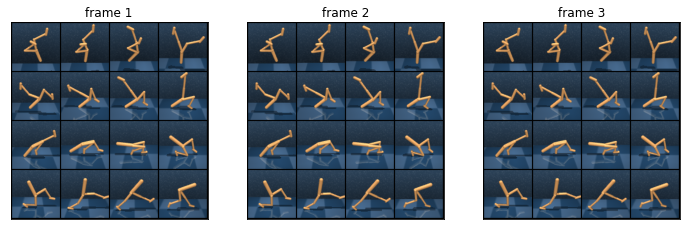

In [3]:
from torchvision.utils import make_grid

def show_imgs(x,max_display=16):
    grid = make_grid(torch.from_numpy(x[:max_display]),4).permute(1,2,0).cpu().numpy()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(grid)
    
def show_stacked_imgs(x,max_display=16):
    
    fig=plt.figure(figsize=(12, 12))
    stack = 3
  
    for i in range(1, stack +1):
        grid = make_grid(torch.from_numpy(x[:max_display,(i-1)*3:i*3,...]),4).permute(1,2,0).cpu().numpy()
        
        fig.add_subplot(1, stack, i)
        plt.xticks([])
        plt.yticks([])
        plt.title('frame ' + str(i))
        plt.imshow(grid)


show_stacked_imgs(stacked_x)

# Random Crop

0.006375789642333984


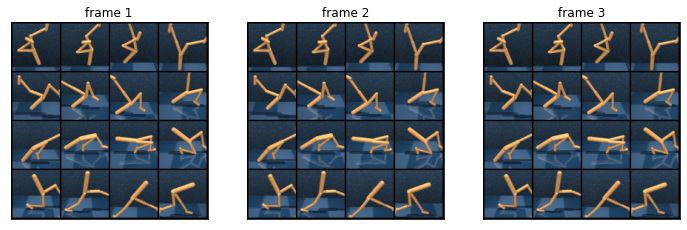

In [4]:
import numpy as np

def random_crop(imgs, out):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    crop_max = h - out + 1
    w1 = np.random.randint(0, crop_max, n)
    h1 = np.random.randint(0, crop_max, n)
    cropped = np.empty((n, c, out, out), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        
        cropped[i] = img[:, h11:h11 + out, w11:w11 + out]
    return cropped

start = time()
cropped_x = random_crop(stacked_x,64)
end = time()-start
print(end)
show_stacked_imgs(cropped_x)


# Random Grayscale

Notes: inputs torch tensor (but can also be refactored to input numpy array). The reason is that matrix multiplication is much faster on GPU, which we need for calculating grayscale `imgs[:, :, 0, ...] * 0.2989 + imgs[:, :, 1, ...] * 0.587 + imgs[:, :, 2, ...] * 0.114 `.

CPU time 0.021604299545288086
GPU time 0.006219625473022461
GPU is 3.5X faster than CPU


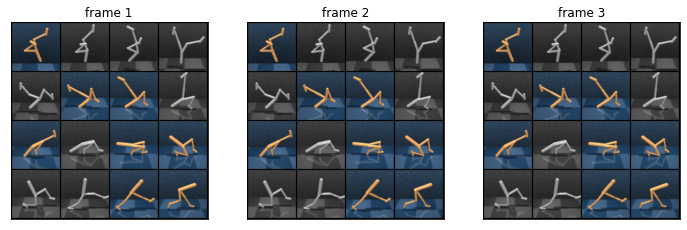

In [6]:

def grayscale(imgs,device):
    # imgs: b x c x h x w
    b, c, h, w = imgs.shape
    frames = c // 3
    
    imgs = imgs.view([b,frames,3,h,w])
    imgs = imgs[:, :, 0, ...] * 0.2989 + imgs[:, :, 1, ...] * 0.587 + imgs[:, :, 2, ...] * 0.114 
    
    imgs = imgs.type(torch.uint8).float()
    # assert len(imgs.shape) == 3, imgs.shape
    imgs = imgs[:, :, None, :, :]
    imgs = imgs * torch.ones([1, 1, 3, 1, 1], dtype=imgs.dtype).float().to(device) # broadcast tiling
    return imgs

def random_grayscale(images,device,p=.5):
    # images: [B, C, H, W]
    bs, channels, h, w = images.shape
    images = images.to(device)
    gray_images = grayscale(images,device)
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    mask = rnd <= p
    mask = torch.from_numpy(mask)
    frames = images.shape[1] // 3
    images = images.view(*gray_images.shape)
    mask = mask[:, None] * torch.ones([1, frames]).type(mask.dtype)
    mask = mask.type(images.dtype).to(device)
    mask = mask[:, :, None, None, None]
    out = mask * gray_images + (1 - mask) * images
    out = out.view([bs, -1, h, w])
    return out.type(torch.uint8)


device = torch.device('cpu')

start = time()
gray_x = random_grayscale(torch.from_numpy(stacked_x),device)
end = time()
cpu_time = end-start
print('CPU time',cpu_time)

device = torch.device('cuda')

start = time()
gray_x = random_grayscale(torch.from_numpy(stacked_x),device)
end = time()
gpu_time = end-start
print('GPU time',gpu_time)

print('GPU is',str(round(cpu_time/gpu_time,1))+'X','faster than CPU')
show_stacked_imgs(gray_x.cpu().numpy())

# Random Cutout

Notes: inputs and outputs numpy array, quite fast on CPU.

0.009463071823120117


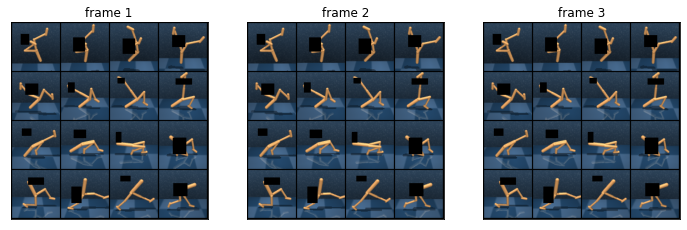

In [7]:
import numpy as np

def random_cutout(imgs, min_cut,max_cut):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)
    
    cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        cut_img = img.copy()
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = 0
        #print(img[:, h11:h11 + h11, w11:w11 + w11].shape)
        cutouts[i] = cut_img
    return cutouts

start = time()
cut_x = random_cutout(stacked_x,10,30)
end = time()-start
print(end)
show_stacked_imgs(cut_x)




# Random Flip


CPU time 0.036512136459350586
GPU time 0.004189729690551758
GPU is 8.7X faster than CPU


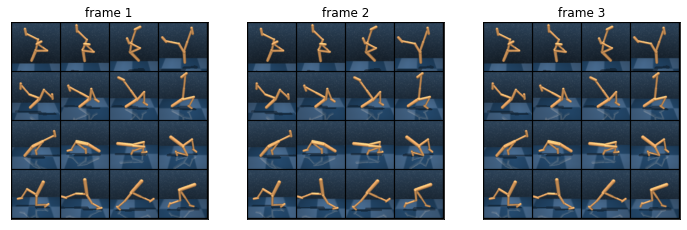

In [8]:
def random_flip(images,device,p=.5):
    # images: [B, C, H, W]
    bs, channels, h, w = images.shape
    
    images = images.to(device)

    flipped_images = images.flip([3])
    
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    mask = rnd <= p
    mask = torch.from_numpy(mask)
    frames = images.shape[1] #// 3
    images = images.view(*flipped_images.shape)
    mask = mask[:, None] * torch.ones([1, frames]).type(mask.dtype)
    
    mask = mask.type(images.dtype).to(device)
    mask = mask[:, :, None, None]
    
    out = mask * flipped_images + (1 - mask) * images

    out = out.view([bs, -1, h, w])
    return out.type(torch.uint8)



device = torch.device('cpu')

start = time()
flipped_x = random_flip(torch.from_numpy(stacked_x),device)
end = time()
cpu_time = end-start
print('CPU time',cpu_time)

device = torch.device('cuda')

start = time()
flipped_x = random_flip(torch.from_numpy(stacked_x),device)
end = time()
gpu_time = end-start
print('GPU time',gpu_time)

print('GPU is',str(round(cpu_time/gpu_time,1))+'X','faster than CPU')
show_stacked_imgs(flipped_x.cpu().numpy())

# Random Rotation

CPU time 0.17045831680297852
GPU time 0.009972095489501953
GPU is 17.1X faster than CPU


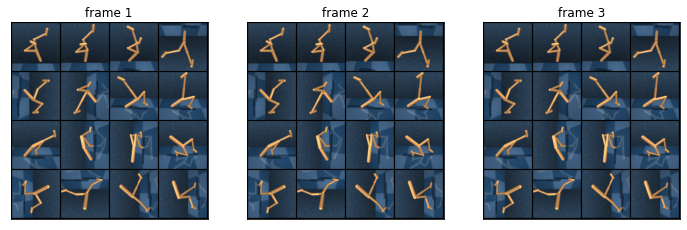

In [9]:
def random_rotation(images,device,p=.5):
    # images: [B, C, H, W]
    bs, channels, h, w = images.shape
    
    images = images.to(device)

    rot90_images = images.rot90(1,[2,3])
    rot180_images = images.rot90(2,[2,3])
    rot270_images = images.rot90(3,[2,3])    
    
    rnd = np.random.uniform(0., 1., size=(images.shape[0],))
    rnd_rot = np.random.randint(1, 4, size=(images.shape[0],))
    mask = rnd <= p
    mask = rnd_rot * mask
    mask = torch.from_numpy(mask).to(device)
    
    frames = images.shape[1]
    masks = [torch.zeros_like(mask) for _ in range(4)]
    for i,m in enumerate(masks):
        m[torch.where(mask==i)] = 1
        m = m[:, None] * torch.ones([1, frames]).type(mask.dtype).type(images.dtype).to(device)
        m = m[:,:,None,None]
        masks[i] = m
    
    
    out = masks[0] * images + masks[1] * rot90_images + masks[2] * rot180_images + masks[3] * rot270_images

    out = out.view([bs, -1, h, w])
    return out.type(torch.uint8)

device = torch.device('cpu')

start = time()
flipped_x = random_rotation(torch.from_numpy(stacked_x),device)
end = time()
cpu_time = end-start
print('CPU time',cpu_time)

device = torch.device('cuda')

start = time()
flipped_x = random_rotation(torch.from_numpy(stacked_x),device)
end = time()
gpu_time = end-start
print('GPU time',gpu_time)

print('GPU is',str(round(cpu_time/gpu_time,1))+'X','faster than CPU')
show_stacked_imgs(flipped_x.cpu().numpy())

# Random Cutout V2

Notes: inputs and outputs numpy array, quite fast on CPU.

0.012464761734008789


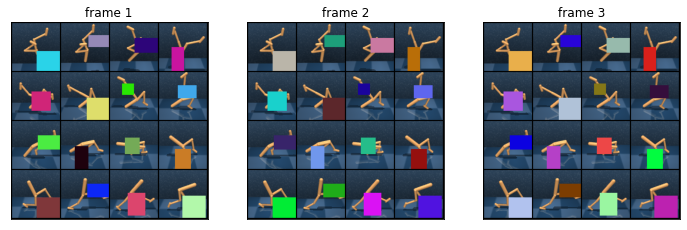

In [10]:
import numpy as np

def random_cutout_color(imgs, min_cut,max_cut):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)
    
    cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    rand_box = np.random.randint(0, 255, size=(n, c), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        cut_img = img.copy()
        
        # add random box
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = np.tile(
            rand_box[i].reshape(-1,1,1),                                                
            (1,) + cut_img[:, h11:h11 + h11, w11:w11 + w11].shape[1:])
        
        cutouts[i] = cut_img
    return cutouts

start = time()
cut_x = random_cutout_color(stacked_x,20,50)
end = time()-start
print(end)
show_stacked_imgs(cut_x)

# Random Convolution

Notes: input is torch tensor with [0..1] because this augmentation is based on convolution. Also, output is not with in [0..1] or [0..255] (it is random vector).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CPU time 1.1459729671478271
GPU time 0.040261030197143555
GPU is 28.5X faster than CPU


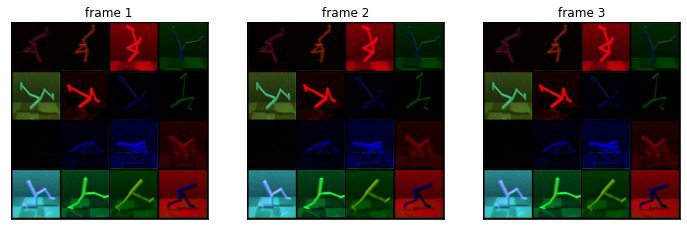

In [11]:
import torch.nn as nn

def random_convolution(imgs, num_trans=10):
    '''
    random covolution in "network randomization"
    
    (imbs): B x (C x stack) x H x W, note: imgs should be normalized and torch tensor
    '''
    _device = imgs.device
    
    img_h, img_w = imgs.shape[2], imgs.shape[3]
    num_stack_channel = imgs.shape[1]
    num_batch = imgs.shape[0]
    batch_size = int(num_batch / num_trans)
    
    # initialize random covolution
    rand_conv = nn.Conv2d(3, 3, kernel_size=3, bias=False, padding=1).to(_device)
    
    for trans_index in range(num_trans):
        torch.nn.init.xavier_normal_(rand_conv.weight.data)
        temp_imgs = imgs[trans_index*batch_size:(trans_index+1)*batch_size]
        temp_imgs = temp_imgs.reshape(-1, 3, img_h, img_w) # (batch x stack, channel, h, w)
        rand_out = rand_conv(temp_imgs)
        if trans_index == 0:
            total_out = rand_out
        else:
            total_out = torch.cat((total_out, rand_out), 0)
    total_out = total_out.reshape(-1, num_stack_channel, img_h, img_w)
    return total_out


device = torch.device('cpu')
in_stacked_x = torch.from_numpy(stacked_x).to(device)
in_stacked_x= in_stacked_x / 255.0

start = time()
randconv_x = random_convolution(in_stacked_x, num_trans=in_stacked_x.shape[0])
end = time()
cpu_time = end-start
print('CPU time',cpu_time)

device = torch.device('cuda')
in_stacked_x = torch.from_numpy(stacked_x).to(device)
in_stacked_x= in_stacked_x / 255.0
start = time()
randconv_x = random_convolution(in_stacked_x,  num_trans=in_stacked_x.shape[0])
end = time()
gpu_time = end-start
print('GPU time',gpu_time)

print('GPU is',str(round(cpu_time/gpu_time,1))+'X','faster than CPU')
show_stacked_imgs(randconv_x.data.cpu().numpy())

# Random Color-jitter

Notes: input is torch tensor with [0..1] because this augmentation is based on convolution.

CPU time 0.44600534439086914
GPU time 0.04261064529418945
GPU is 10.5X faster than CPU


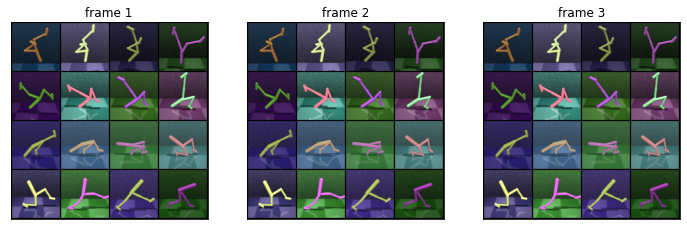

In [12]:
transform_module = nn.Sequential(ColorJitterLayer(brightness=0.4, 
                                                  contrast=0.4,
                                                  saturation=0.4, 
                                                  hue=0.5, 
                                                  p=1.0, 
                                                  batch_size=128))

device = torch.device('cpu')
in_stacked_x = torch.from_numpy(stacked_x).to(device)
in_stacked_x= in_stacked_x / 255.0
in_stacked_x = in_stacked_x.reshape(-1,3,84,84)
start = time()
randconv_x = transform_module(in_stacked_x)
end = time()
cpu_time = end-start
print('CPU time',cpu_time)

device = torch.device('cuda')
in_stacked_x = torch.from_numpy(stacked_x).to(device)
in_stacked_x= in_stacked_x / 255.0
in_stacked_x = in_stacked_x.reshape(-1,3,84,84)

start = time()
randconv_x = transform_module(in_stacked_x)
randconv_x = randconv_x.reshape(-1, 9, 84,84)
end = time()
gpu_time = end-start
print('GPU time',gpu_time)

print('GPU is',str(round(cpu_time/gpu_time,1))+'X','faster than CPU')
show_stacked_imgs(randconv_x.data.cpu().numpy())